In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, r2_score
from pipeline import get_fitted_pipeline

In [2]:
train_data = pd.read_csv(r"/Users/loganheydt/Desktop/Data/GitHub/house_prices/data/train.csv")

test_data = pd.read_csv(r"/Users/loganheydt/Desktop/Data/GitHub/house_prices/data/test.csv")

y = train_data["SalePrice"]
x = train_data.drop(columns=["SalePrice"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)

fitted_pipeline, x_train = get_fitted_pipeline(x_train)

x_test = fitted_pipeline.transform(x_test)

y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# Exploration

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
na_counts = train_data.isna().sum()

na_percent = (train_data.isna().mean() * 100).round(2)

missing_report = pd.DataFrame({
    "MissingCount": na_counts,
    "MissingPct": na_percent
}).sort_values("MissingCount", ascending=False)

missing_report.head(20)

,MissingCount,MissingPct
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55


In [5]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

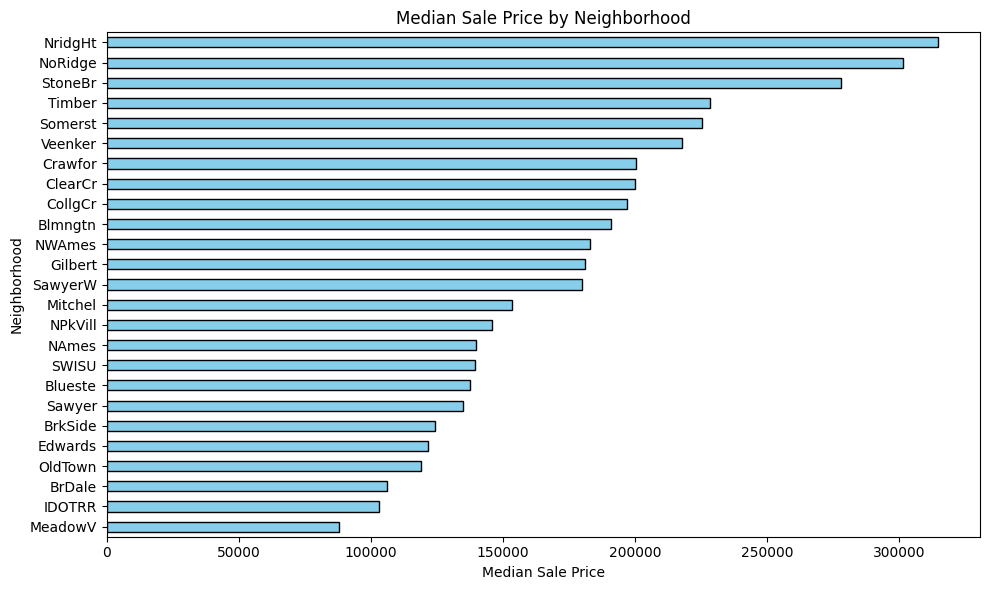

In [7]:
nbrhood_price = train_data.groupby("Neighborhood")["SalePrice"].median()
nbrhood_price = nbrhood_price.sort_values()

plt.figure(figsize=(10,6))
nbrhood_price.plot(kind="barh", color="skyblue", edgecolor="black")
plt.title("Median Sale Price by Neighborhood")
plt.xlabel("Median Sale Price")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()

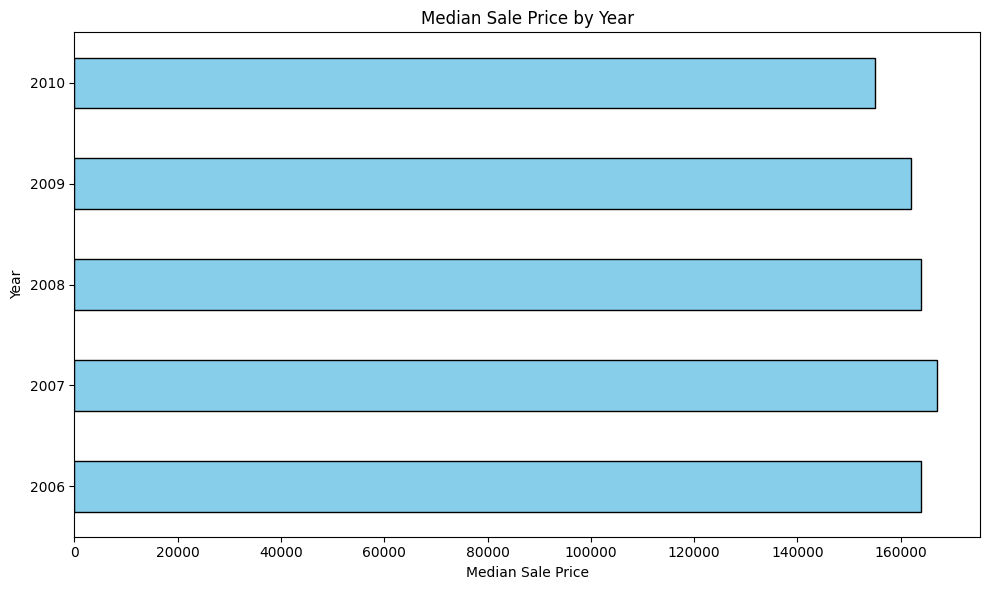

In [8]:
year_price = train_data.groupby("YrSold")["SalePrice"].median()
# year_price = year_price.sort_values()

plt.figure(figsize=(10,6))
year_price.plot(kind="barh", color="skyblue", edgecolor="black")
plt.title("Median Sale Price by Year")
plt.xlabel("Median Sale Price")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

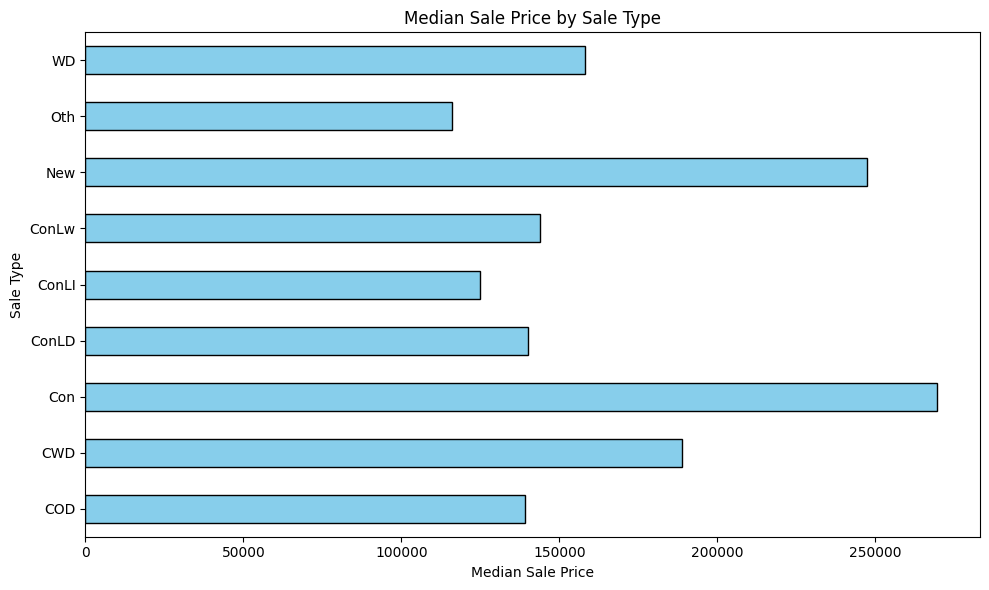

In [9]:
saletype_price = train_data.groupby("SaleType")["SalePrice"].median()

plt.figure(figsize=(10,6))
saletype_price.plot(kind="barh", color="skyblue", edgecolor="black")
plt.title("Median Sale Price by Sale Type")
plt.xlabel("Median Sale Price")
plt.ylabel("Sale Type")
plt.tight_layout()
plt.show()

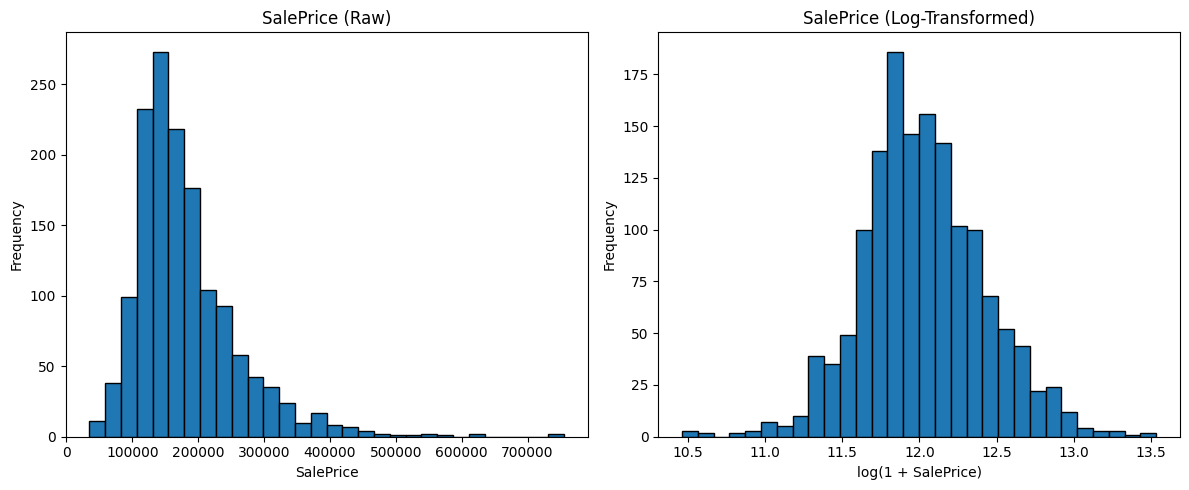

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# raw
axes[0].hist(y, bins=30, edgecolor="black")
axes[0].set_title("SalePrice (Raw)")
axes[0].set_xlabel("SalePrice")
axes[0].set_ylabel("Frequency")

# log-transformed
axes[1].hist(np.log1p(y), bins=30, edgecolor="black")
axes[1].set_title("SalePrice (Log-Transformed)")
axes[1].set_xlabel("log(1 + SalePrice)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

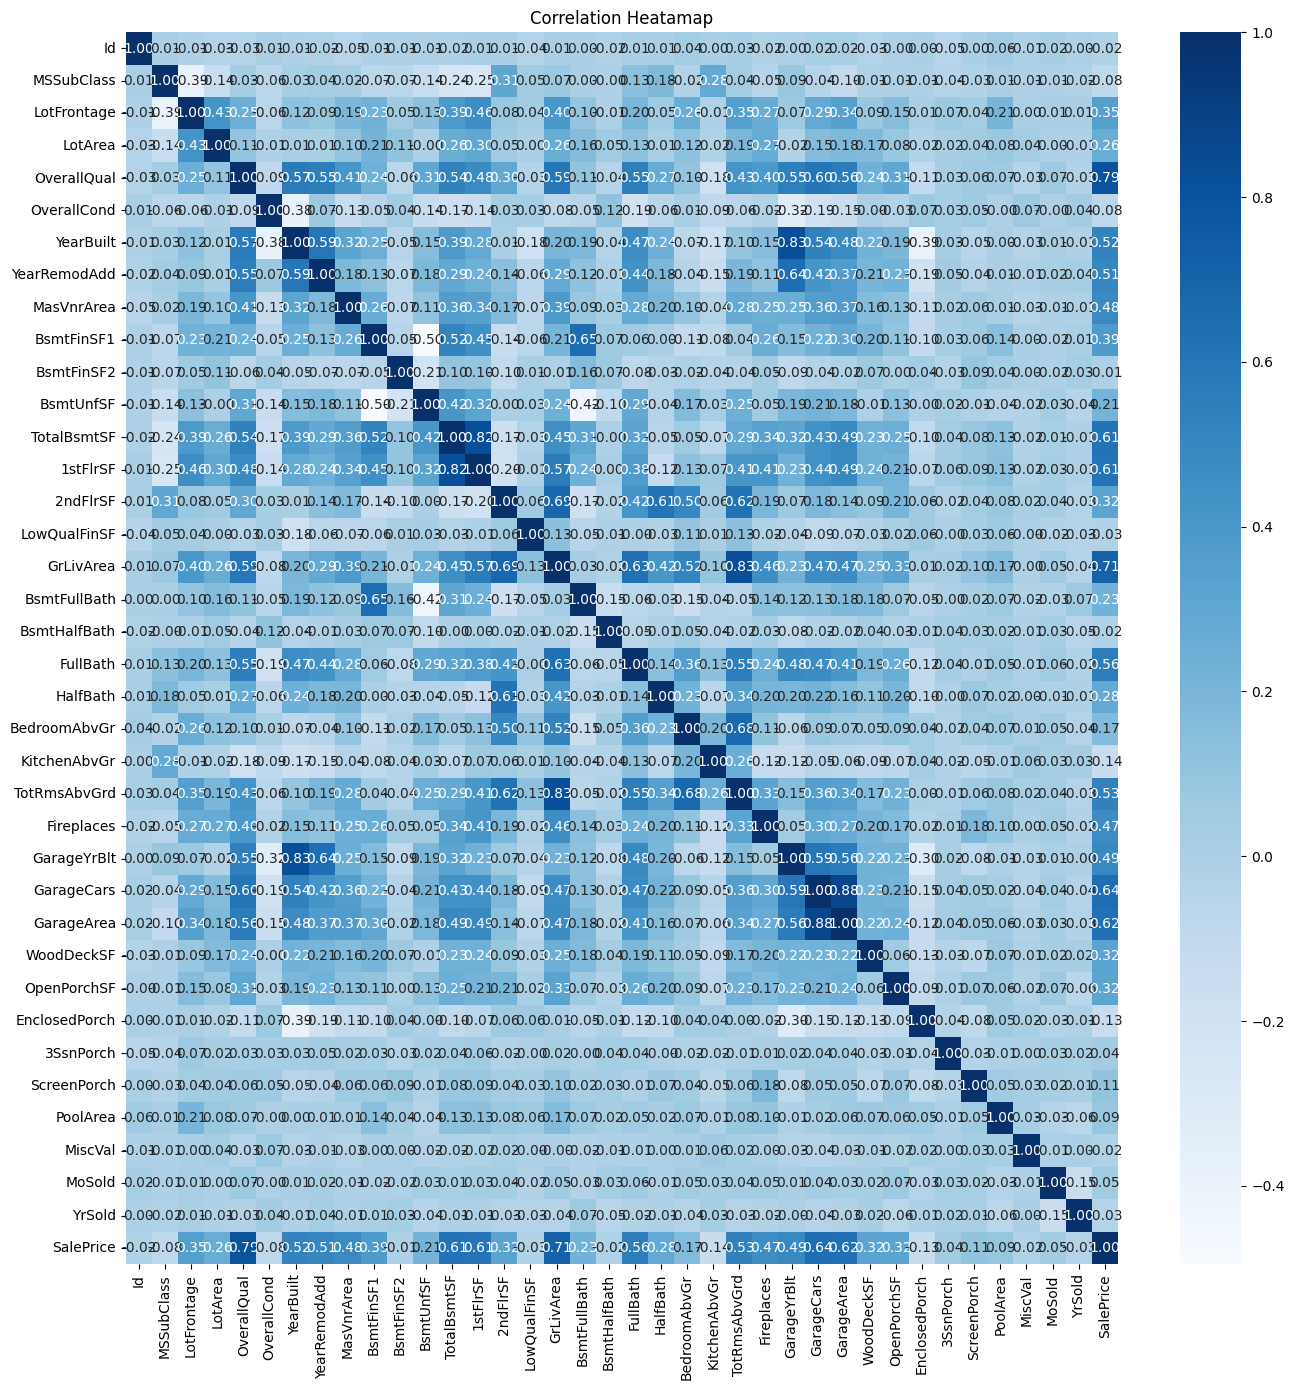

In [11]:
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

corr = train_data[numeric_cols].corr()

plt.figure(figsize=(16,16))
sns.heatmap(corr, cmap='Blues', annot=True, fmt=".2f")
plt.title("Correlation Heatamap")
plt.show()


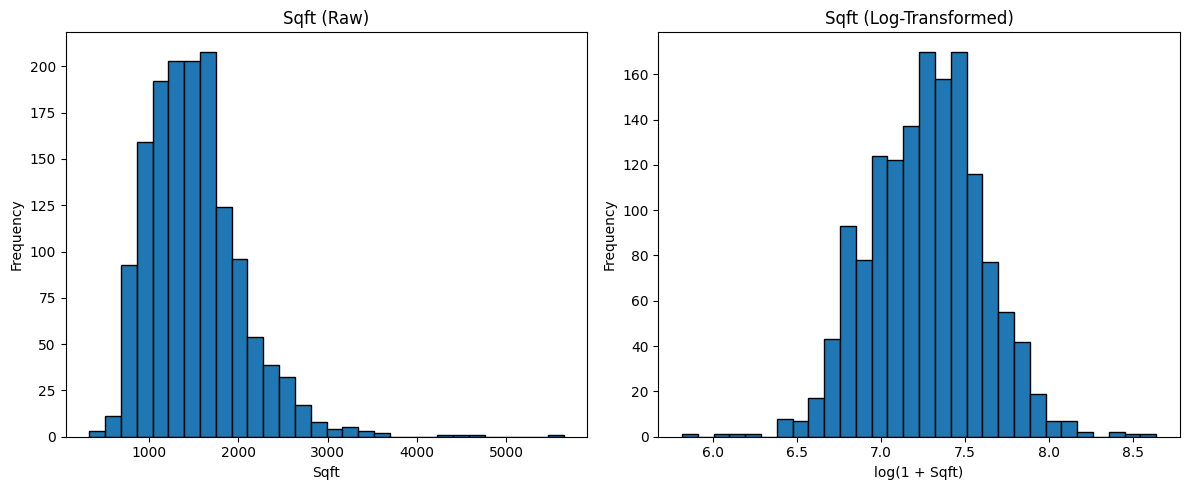

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sqft = x['GrLivArea']

# raw
axes[0].hist(sqft, bins=30, edgecolor="black")
axes[0].set_title("Sqft (Raw)")
axes[0].set_xlabel("Sqft")
axes[0].set_ylabel("Frequency")

# log-transformed
axes[1].hist(np.log1p(sqft), bins=30, edgecolor="black")
axes[1].set_title("Sqft (Log-Transformed)")
axes[1].set_xlabel("log(1 + Sqft)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

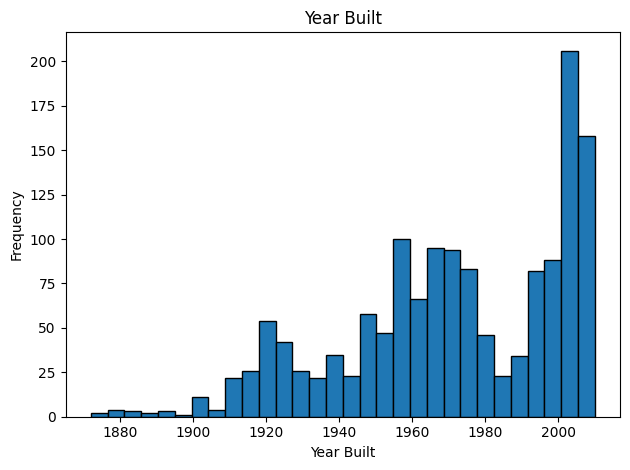

In [13]:
yrblt = x['YearBuilt']

plt.hist(yrblt, bins=30, edgecolor="black")
plt.title("Year Built")
plt.xlabel("Year Built")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

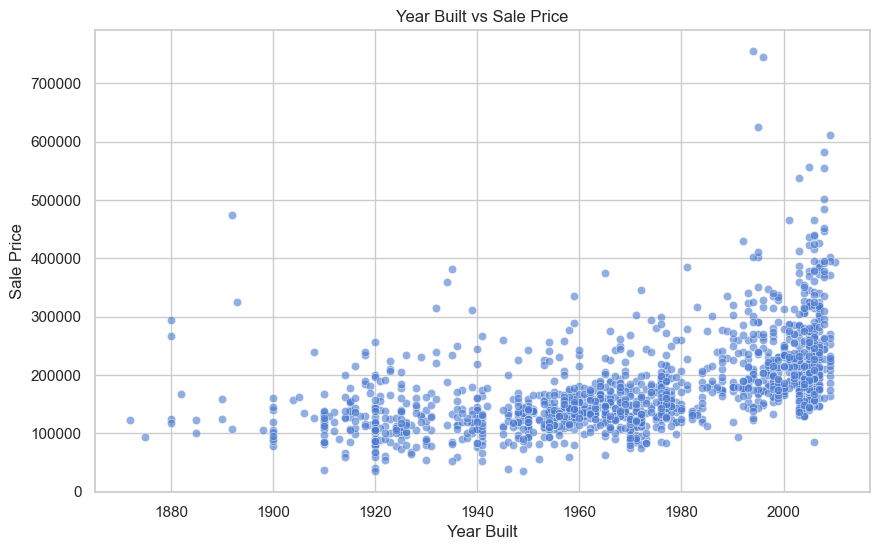

In [14]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 6))

plt.figure(figsize=(10, 6))
sns.scatterplot(x="YearBuilt", y="SalePrice", data=train_data, alpha=0.6)
plt.title("Year Built vs Sale Price")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.show()


<Figure size 1200x600 with 0 Axes>

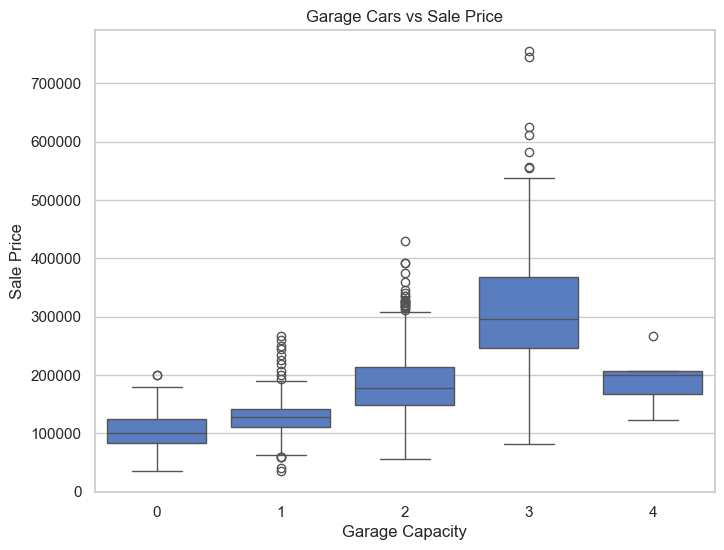

In [15]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 6))

plt.figure(figsize=(8, 6))
sns.boxplot(x="GarageCars", y="SalePrice", data=train_data)
plt.title("Garage Cars vs Sale Price")
plt.xlabel("Garage Capacity")
plt.ylabel("Sale Price")
plt.show()

<Figure size 1200x600 with 0 Axes>

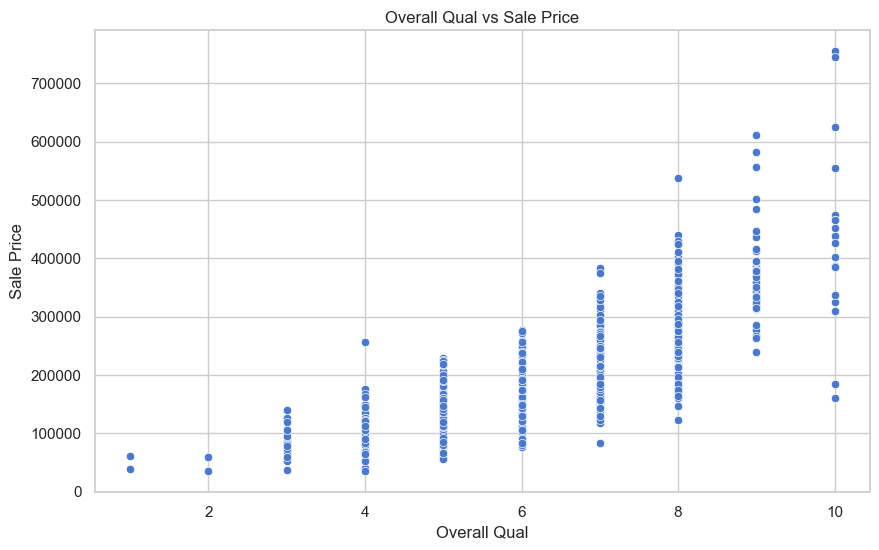

In [16]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 6))

plt.figure(figsize=(10, 6))
sns.scatterplot(x="OverallQual", y="SalePrice", data=train_data)
plt.title("Overall Qual vs Sale Price")
plt.xlabel("Overall Qual")
plt.ylabel("Sale Price")
plt.show()

In [17]:
cat_cols = [c for c in x_train.columns if str(x_train[c].dtype) in ("object","string","category")]

est = CatBoostRegressor(
    loss_function="RMSE",
    random_state=42,
    od_type="Iter", od_wait=150,       
    iterations=1200,                     
    rsm=0.8,                             
    border_count=64,                     
    thread_count=-1,                     
    verbose=False,                       
    bootstrap_type="Bayesian",
    allow_writing_files=False
)


param_grid = {
    "depth": [6, 8],
    "learning_rate": [0.05, 0.08],
    "l2_leaf_reg": [3, 10],
    "bagging_temperature": [0, 1]
}

gs = GridSearchCV(est, param_grid=param_grid, cv=3, n_jobs=-1, refit=True)

gs.fit(x_train, y_train_log, cat_features=cat_cols, eval_set=(x_test, y_test_log), verbose=False)

best = gs.best_estimator_
pred_log = best.predict(x_test)
pred = np.expm1(pred_log)

In [18]:
pred_df = pd.DataFrame(pred)

In [19]:

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)
mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

print("=== Model Accuracy ===")
print(f"RMSE : {rmse:,.0f}")
print(f"MAE  : {mae:,.0f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

=== Model Accuracy ===
RMSE : 26,769
MAE  : 17,034
R²   : 0.8973
MAPE : 9.81%


In [20]:
# === Model Accuracy on Original Scale ===
# RMSE : 26,769
# MAE  : 17,034
# R²   : 0.8973
# MAPE : 9.81%


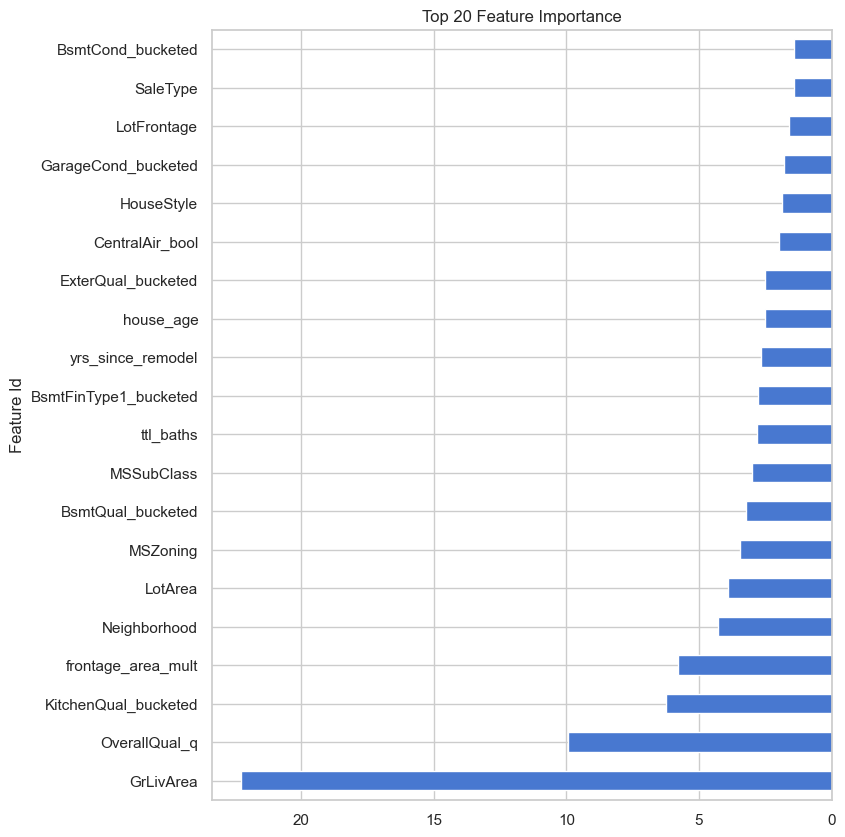

In [21]:
importance = best.get_feature_importance(prettified=True)
# print(importance)

top_n = 20
importance.head(top_n).plot(
    x = 'Feature Id', y= 'Importances', kind = 'barh', figsize= (8,10),
    legend=False
)
plt.title(f"Top {top_n} Feature Importance")
plt.gca().invert_xaxis()
plt.show()


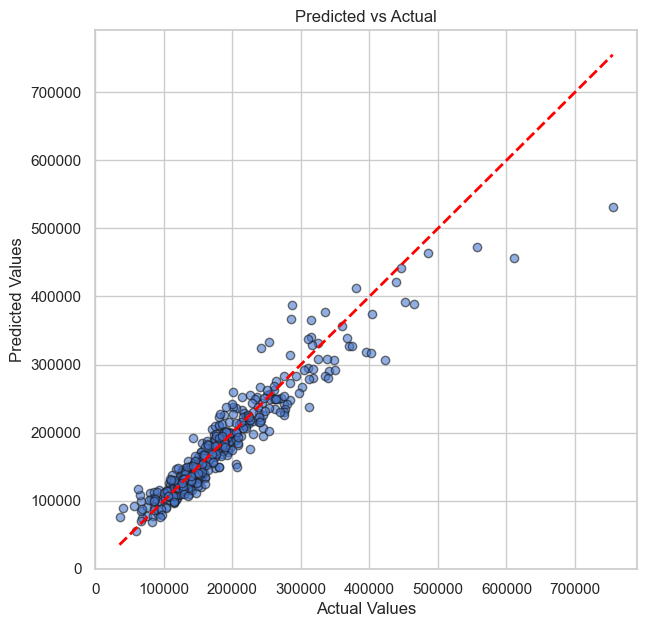

In [22]:
y_actual = np.expm1(y_test_log)
y_pred = pred  # already back-transformed

plt.figure(figsize=(7,7))
plt.scatter(y_actual, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_actual.min(), y_actual.max()],
         [y_actual.min(), y_actual.max()],
         color="red", linestyle="--", linewidth=2)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")
plt.show()